In [20]:
import sys
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
import math
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

sys.path.insert(0, "../")
from eval_metrics import lift_at_k

from cleanlab.rank import order_label_issues, get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.filter import find_label_issues

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Evaluate scores

In [11]:
%%time

models = [
    "resnet18", 
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

results_list = []
pred_probs_list = [] # use for ensemble scoring
labels_list = [] # use for sanity check (labels from each model should be the same because they were generated from the same cross-val procedure

for model in models:
    
    # read numpy files
    numpy_out_folder = f"./roman-numeral_train_val_dataset_cv_{model}/" # path to cross-val output
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "labels.npy") # given label
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    label_errors_target = np.load(numpy_out_folder + "label_errors_mask.npy") # known label errors
    
    # save to list for ensemble scoring
    pred_probs_list.append(pred_probs)
    
    labels_list.append(labels)
    
    for score_param in score_params:
        
        method, adjust_pred_probs = score_param

        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        
        # lift at number of errors
        lift_at_num_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())

        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(100, 500, 100):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)

        # save results
        results = {
            "dataset": "andrew-ng-dcai",
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc,
            "lift_at_num_errors": lift_at_num_errors
        }

        # add the lift at k metrics
        results.update(lift_at_k_dict)

        # save results
        results_list.append(results)

CPU times: user 1.6 s, sys: 3.81 ms, total: 1.61 s
Wall time: 1.61 s


In [12]:
# use for sanity check (noisy labels from each model should be the same because they were generated from the same cross-val procedure
for i, labels_temp in enumerate(labels_list):
    if i == 0:
        labels_temp_previous = labels_temp.copy()
    else:
        assert (labels_temp_previous == labels_temp).all()

## Evaluate ensemble scores

In [13]:
%%time

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_ensemble_scores = get_label_quality_ensemble_scores(labels, pred_probs_list, method=method, adjust_pred_probs=adjust_pred_probs)
    
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_ensemble_scores)
    
    # lift at number of errors
    lift_at_num_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())    
    
    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(100, 500, 100):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_ensemble_scores, k=k)

    # save results
    results = {
        "dataset": "andrew-ng-dcai",
        "model": "ensemble (all)",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc,
        "lift_at_num_errors": lift_at_num_errors
    }

    # add the lift at k metrics
    results.update(lift_at_k_dict)
    
    # save results
    results_list.append(results)

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.7831155068880254
  Model 0 weights  : 0.203843324751747
  Model 1 accuracy : 0.7089367714588485
  Model 1 weights  : 0.18453475542478853
  Model 2 accuracy : 0.7114093959731543
  Model 2 weights  : 0.18517837440235382
  Model 3 accuracy : 0.8163193217944189
  Model 3 weights  : 0.21248620816476646
  Model 4 accuracy : 0.8219710349699753
  Model 4 weights  : 0.21395733725634425
Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.7831155068880254
  Model 0 weights  : 0.203843324751747
  Model 1 accuracy : 0.7089367714588485
  Model 1 weights  : 0.18453475542478853
  Model 2 accuracy : 0.7114093959731543
  Model 2 weights  : 0.185178374402353

## Create DataFrame with results

In [14]:
df = pd.DataFrame(results_list)

In [16]:
# results for best model: Swin Transformer
df[df.model == "swin_base_patch4_window7_224"]

,dataset,model,method,adjust_pred_probs,auroc,lift_at_num_errors,lift_at_100,lift_at_200,lift_at_300,lift_at_400
20,andrew-ng-dcai,swin_base_patch4_window7_224,self_confidence,False,0.834956,4.050598,5.783763,5.212997,4.490027,3.995363
21,andrew-ng-dcai,swin_base_patch4_window7_224,self_confidence,True,0.837348,4.111971,6.240376,5.327151,4.692966,4.033414
22,andrew-ng-dcai,swin_base_patch4_window7_224,normalized_margin,False,0.824684,3.886938,4.337823,4.147567,3.906577,3.786082
23,andrew-ng-dcai,swin_base_patch4_window7_224,normalized_margin,True,0.821768,3.846023,4.337823,4.033414,3.906577,3.709980
24,andrew-ng-dcai,swin_base_patch4_window7_224,confidence_weighted_entropy,False,0.836609,4.173344,6.164274,4.984691,4.490027,3.976337


## Export results to csv

In [39]:
# export results to CSV file
ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)

## Display top images ranked by label quality scores

In [6]:
# read pred_probs (again)

model = "swin_base_patch4_window7_224"
method = "self_confidence"
adjust_pred_probs = False

numpy_out_folder = f"./roman-numeral_train_val_dataset_cv_{model}/"
pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
label_errors_target = np.load(numpy_out_folder + "label_errors_mask.npy") # known label errors

# get label quality scores (again)
label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

In [7]:
df_temp = pd.DataFrame({
    "label_quality_scores": label_quality_scores,
    "images": images,
    "labels": labels,
    "label_errors_target": label_errors_target
})

prefix = "/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/" # path to dataset
df_temp["file_paths"] = df_temp.images.map(lambda x: prefix + "/".join(Path(x).parts[-3:]))

In [83]:
# df_temp.sort_values(by="label_quality_scores", ascending=True).head(2)

Text(0.5, 0.98, 'Top 20 Images Ordered By Label Quality Score \n Scoring Method: Self Confidence \n Model: Swin Transformer')

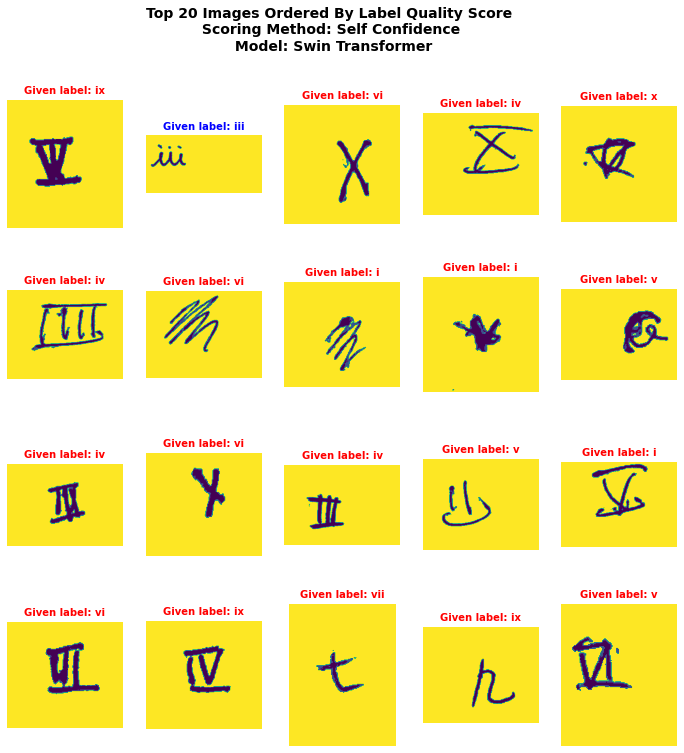

In [11]:
TOP_K = 20
df_filtered = df_temp.sort_values(by="label_quality_scores", ascending=True).head(TOP_K)

# list of image paths
# e.g. "../data/train/i/foo.png"
image_paths = df_filtered.file_paths.tolist()
image_labels = df_filtered.labels.tolist()
image_errors = df_filtered.label_errors_target.tolist()

# count of images
image_cnt = len(image_paths)

# configure grid
GRID_SAVE_PATH = f"./top_{TOP_K}_images_by_{model}_{method}_grid.png"

fig_size = 12  # resolution; 1 = 100px
num_cols = 5  # set the number of desired columns
num_rows = math.ceil(
    image_cnt / num_cols
)  # number of rows will be automatically set
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, fig_size))

# loop through each image
for idx, image_path in enumerate(image_paths):

    # given label
    given_label = Path(image_path).parts[-2]

    # set the position of the image on the grid
    row_pos = idx // num_cols
    col_pos = idx % num_cols

    # read image
    plt_image = plt.imread(image_path)

    # show image
    axes[row_pos, col_pos].axis("off")
    #     axes[row_pos, col_pos].set_facecolor('xkcd:salmon')

    error = image_errors[idx]
    title_color = ("b", "r")[error]

    axes[row_pos, col_pos].set_title(
        f"Given label: {given_label}", size=10, fontweight="bold", color=title_color
    )
    axes[row_pos, col_pos].imshow(plt_image)

plt.suptitle(f"Top 20 Images Ordered By Label Quality Score \n Scoring Method: Self Confidence \n Model: Swin Transformer", size=14, fontweight="bold")
# plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
# plt.savefig(GRID_SAVE_PATH)